# Models comparison without features selection and wuth hyperparameters optimization

## Imports

In [2]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from xgboost import XGBClassifier
import pandas as pd
import catboost as cb
import numpy as np
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform
from tqdm.notebook import tqdm
import pickle
from datetime import datetime

## Load data

In [3]:
# Load genus relative abundance data as features
# X = pd.read_csv("https://raw.githubusercontent.com/per6x/CSE3000/master/kraken_taxonomy/genus_relative_abundance.csv", sep=";")
# Load species relative abundance data as features
X = pd.read_csv("https://raw.githubusercontent.com/per6x/CSE3000/master/kraken_taxonomy/species_relative_abundance.csv", sep=";")
# Load labels 
y = pd.read_csv("https://raw.githubusercontent.com/per6x/CSE3000/master/labels.csv", sep=";")
y = y.set_index("Sample", drop=True)["Class"]
X = X.set_index("Sample", drop=True)
print(X.shape)
assert X.shape[0] == y.shape[0]

(212, 4630)


## Split the data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_pool = cb.Pool(data=X_train, label=y_train)
full_pool = cb.Pool(data=X, label=y)

## Define K-Fold, models and param distributions

In [5]:
# K-Fold
skf = StratifiedKFold(n_splits=10, shuffle=True)
# models
models = {
  # 'CatBoost': cb.CatBoostClassifier(thread_count=-1, verbose=False, random_state=42),
  'XGBoost': XGBClassifier(n_jobs=-1, random_state=42),
  'RF': RandomForestClassifier(warm_start=True, n_jobs=-1, random_state=42),
  'AdaBoost': AdaBoostClassifier(random_state=42),
  'LR': LogisticRegression(warm_start=True, n_jobs=-1, random_state=42),
  'SVM': SVC(random_state=42),
}
# params distributions
param_distributions = {
  'RF': {
    'n_estimators': randint(1, 250),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(1, 20)),
    'min_samples_split': randint(2, 20),
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False],
  },
  'AdaBoost': {
    'n_estimators': randint(1, 250),
    'learning_rate': uniform(0.01, 1.0),
    'estimator': [RandomForestClassifier()],
    'algorithm': ['SAMME', 'SAMME.R'],
    'random_state': [None, 42],
  },
  'XGBoost': {
    'n_estimators': randint(1, 250),
    'learning_rate': uniform(0.01, 1.0),
    'max_depth': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
  },
  'LR': { # Logistic regression
    'C': uniform(0.1, 1.0),
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000],
    'solver': ['liblinear']
  },
  'SVM': {
    'C': uniform(0.1, 1.0),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': randint(1, 3),
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced'],
    'probability': [True, False],
  },
  'CatBoost': {
    'n_estimators': [1000],
    'learning_rate': uniform(0.001, 0.01),
    'depth' : randint(4, 10),
    'l2_leaf_reg' : randint(2, 10),
    'random_strength' : uniform(0, 10),
    'subsample': uniform(0.6, 0.4),
    'loss_function': ['Logloss'],
  }
}

## Randomized search with cross validation

In [9]:
# define metrics
# metrics = ['accuracy', 'f1', 'roc_auc']
# dict for cv results
random_search_results = {}

for m_name, model in (p_bar := tqdm(models.items())):
    p_bar.set_description(f'Running RandomizedSearchCV for {m_name}')
    random_search = RandomizedSearchCV(
      model,
      param_distributions=param_distributions[m_name],
      n_iter=60,
      cv=skf,
      random_state=42,
      n_jobs=-1,
      scoring="roc_auc",
    )
    random_search.fit(X, y)
    random_search_results[m_name] = random_search

  0%|          | 0/5 [00:00<?, ?it/s]

NameError: name 'random_search_results' is not defined

In [6]:
# roc_auc_score(y_test, random_search.best_estimator_.predict(X_test))
with open(f'randomized_search_{datetime.now().strftime("%d.%m.%Y_%H.%M.%S")}.p', 'wb') as fp:
    pickle.dump(random_search_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
random_search_results['CatBoost'].best_params_

{'depth': 8,
 'l2_leaf_reg': 5,
 'learning_rate': 0.01083423140894843,
 'loss_function': 'Logloss',
 'n_estimators': 1000,
 'random_strength': 3.9882444244455306,
 'subsample': 0.9265727492877536}

In [8]:
# cb_rs_results = models['CatBoost'].randomized_search(
#   param_distributions=param_distributions['CatBoost'],
#   X=train_pool,
#   cv=skf,
#   n_iter=2,
#   train_size=0.8,
#   plot=True,
#   refit=True
# )

In [9]:
# feature_importance_df = pd.DataFrame({'feature_importance': models['CatBoost'].get_feature_importance(train_pool), 
#               'feature_names': X.columns}).sort_values(by=['feature_importance'], 
#                                                            ascending=False)
# feature_importance_df[:100]

## Cross validate models on metrics

In [19]:
# define metrics
metrics = ['accuracy', 'f1', 'roc_auc']
# dict for cv results 
cv_results = {}

for m_name, model in (p_bar := tqdm(models.items())):
  p_bar.set_description(f'Running metrics evaluation for {m_name}')
  
  # Update params with optimized
  model.set_params(**random_search_results[m_name].best_params_)
  print(model.get_params())
  tmp_cv_scores = cross_validate(estimator=model, X=X, y=y, scoring=metrics, cv=skf)
  cv_results[m_name] = tmp_cv_scores

  0%|          | 0/2 [00:00<?, ?it/s]

{'C': 0.22203823484477883, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': True}


/opt/homebrew/Caskroom/miniconda/base/envs/rp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/rp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/rp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/rp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/rp/lib/py

{'C': 0.2818249672071006, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


## Plot the results

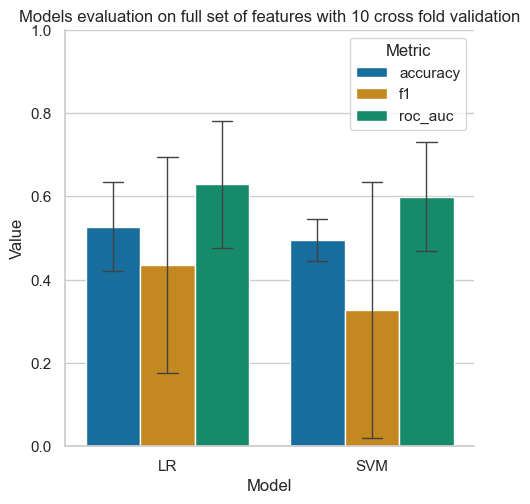

In [20]:
# Create an empty list to hold the data
plot_data = []

# Iterate over the dictionary
for model, values in cv_results.items():
    for key, arr in values.items():
        if key.startswith("test_"):
            for value in arr:
                plot_data.append({"Model": model, "Metric": key[5:], "Value": value})

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(plot_data)

# # Create the plot using Seaborn
sns.set(style="whitegrid")
g = sns.catplot(data=df,
                x="Model",
                y="Value",
                hue="Metric",
                kind="bar",
                estimator=np.mean,
                errorbar='sd',
                capsize=0.1,
                errwidth=1,
                legend=True,
                sharex=False,
                sharey=False,
                legend_out=False,
                palette='colorblind'
)
g.set(ylim=(0, 1.0))
# Add labels and title to the plot
plt.xlabel("Model")
plt.ylabel("Value")
plt.title("Models evaluation on full set of features with 10 cross fold validation")

# Rotate x-axis labels if needed
# plt.xticks(rotation=45)

# Show the plot
plt.show()